In [220]:
import nltk
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords, brown
from torch.utils.data import TensorDataset, DataLoader
nltk.download('stopwords')
nltk.download('brown')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [221]:
import pandas as pd

df = pd.read_csv('/home/dotronghiep/Documents/Datasets/Social_Listening/DataLabel.csv', header=None)
df.head(10)

,0,1,2
0,1,0,impossible to stop basically means russia is n...
1,2,0,indeed. may russia soil then selves in terror ...
2,3,0,"goodnight family, thanks to everyone for your ..."
3,4,0,keep adding more sanctionsfastest way to get r...
4,5,0,russia does not get to rape ukraine in order t...
5,6,1,its already done de facto. east ukraineand cri...
6,7,1,russia takes most of sievierodonetsk city in e...
7,8,0,biden says us to send ukraine 'advanced rocket...
8,9,1,just in - biden us to send ukraine advanced ro...
9,10,0,why do you suppose i do not understand that. i...


In [222]:
X_row = df.iloc[:, 2].values
y = df.iloc[:, 1].values

In [223]:
# Xác định số lượng mẫu của mỗi lớp
class_0_count = np.sum(y == 0)
class_1_count = np.sum(y == 1)
print(class_0_count,class_1_count)

4108 1663


In [224]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_row, y, test_size=0.2, random_state=42, stratify=y)

# Train the model

In [225]:
print(len(X_train))

4616


In [226]:
print(len(y_train))

4616


In [227]:
# lấy danh sách stopword
stop = set(stopwords.words('english'))
# stop = ()
brown_words = set(word for word in brown.words() if word.lower() not in stop)|{"biden",
                                                                               "ukraine","kiev","kyiv","zelensky", "ukrainian", "ukrainians",
                                                                               "putin","kremlin", "russia", "russian", "russians",
                                                                               "not", "no", "nor", "against", "never", "nobody", "none", "nowhere"}

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [228]:
def lemma(text):
    words = tokenizer.tokenize(text)
    cleaned_words = [lemmatizer.lemmatize(word, pos='v') for word in words if word in brown_words]
    return cleaned_words


# Loại bỏ stop words từ mỗi văn bản trong danh sách X
X_cleaned = [lemma(text) for text in X_train]
X_full = [lemma(text) for text in X_row]

In [229]:
X_cleaned[:10]

[['ukraine', 'every', 'right', 'attack', 'russia', 'point'],
 ['real', 'men', 'defend', 'country', 'people', 'respect'],
 ['well',
  'honest',
  'russian',
  'visit',
  'board',
  'quite',
  'time',
  'russia',
  'start',
  'military',
  'build',
  'ukraine',
  'border',
  'last',
  'year',
  'call',
  'journalist'],
 ['poor',
  'russian',
  'regime',
  'world',
  'say',
  'no',
  'brutal',
  'invasion',
  'play',
  'victim',
  'get',
  'ukraine'],
 ['definitely', 'arm', 'ukraine', 'teeth', 'keep', 'russia'],
 ['legitimate',
  'security',
  'concern',
  'already',
  'countries',
  'members',
  'military',
  'base',
  'nuclear',
  'capability',
  'wipe',
  'russia',
  'map',
  'ukraine',
  'make',
  'zero',
  'difference',
  'putin',
  'know',
  'join',
  'could',
  'not',
  'invade',
  'point'],
 ['ukraine',
  'shut',
  'listen',
  'russia',
  'like',
  'shut',
  'listen',
  'us',
  'argue',
  'otherwise',
  'accept',
  'kind',
  'absurd',
  'prevalent',
  'among',
  'riddle',
  'cat',

In [230]:
import torch
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

In [231]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [232]:
max_length = max(len(sentence) for sentence in X_cleaned)
max_length

36

In [233]:
model = Word2Vec(X_full, 
                 vector_size=100, 
                 window=9, 
                 min_count=5, 
                 workers=8, 
                 epochs=50)
vocabulary = model.wv.index_to_key
print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 2000


In [234]:
# Tìm từ gần nhất 
similar_words = model.wv.most_similar("zelensky")
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

brief: 0.5824
presidents: 0.4392
biden: 0.3970
appeal: 0.3964
onto: 0.3648
display: 0.3617
president: 0.3587
elect: 0.3534
prime: 0.3504
refuse: 0.3475


In [235]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

def vectorize(X, y, model=model):
    X_vectors = []
    y_vectors = []
    # Chuyển từng từ trong mỗi câu thành vector biểu diễn và thêm padding
    for sentence, label in zip(X, y):
        if len(sentence) < 5:
            continue

        sentence_vectors = []
        for i, word in enumerate(sentence):
            # Kiểm tra xem từ đó có trong từ vựng của mô hình Word2Vec hay không
            if i > 35:
                break
            if word in model.wv:
                word_vector = model.wv[word]
                sentence_vectors.append(word_vector)
            else:
                pass

        # Thêm padding cho câu để độ dài của mỗi câu là 35
        while len(sentence_vectors) <= 35:
            sentence_vectors.append(np.zeros((100,)))  # Sử dụng vector zeros cho padding

        # Chuyển danh sách các vector thành một tensor
        sentence_tensor = torch.tensor(sentence_vectors)
        # Thêm câu đã được padding vào danh sách X_vectors
        X_vectors.append(sentence_tensor)
        y_vectors.append(label)


    # Chuyển danh sách X_vectors thành một tensor
    X_padded = np.array(X_vectors)
    y_padded = np.array(y_vectors)
    return X_padded, y_padded
# In ra kích thước của X_padded
X_input, y_input = vectorize(X_cleaned, y_train)
print(X_input.shape)
print(y_input.shape)


(4437, 36, 100)
(4437,)


In [236]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # Khởi tạo hidden state và cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Đưa đầu vào qua LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Lấy output của lớp cuối cùng
        out = self.dropout(out)
        out = self.fc1(out[:, -1, :])
        # out = self.dropout(out)
        # out = self.relu(out)
        # out = self.fc2(out)
        return out.squeeze(1)
    
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # Khởi tạo hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Đưa đầu vào qua RNN
        out, _ = self.rnn(x, h0)
        
        # Lấy output của lớp cuối cùng
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

In [237]:
X_train, X_valid, y_train, y_valid = train_test_split(X_input, y_input, test_size=0.2, stratify=y_input)

# Xác định số lượng mẫu của mỗi lớp
class_0_count = np.sum(y_train == 0)
class_1_count = np.sum(y_train == 1)
# Tính toán số lượng mẫu cần thêm vào mỗi lớp để làm cho số lượng mẫu của hai lớp bằng nhau
samples_to_add = max(class_0_count, class_1_count) - min(class_0_count, class_1_count)

# Lấy mẫu ngẫu nhiên từ các mẫu hiện có trong lớp ít mẫu để tạo ra số lượng mẫu cần thiết và thêm vào tập train
if class_0_count < class_1_count:
    X_train_class_0 = X_train[y_train == 0]
    y_train_class_0 = y_train[y_train == 0]
    additional_indices = np.random.choice(range(class_0_count), samples_to_add)
    X_train_additional = X_train_class_0[additional_indices]
    y_train_additional = y_train_class_0[additional_indices]
    X_train = np.concatenate((X_train, X_train_additional))
    y_train = np.concatenate((y_train, y_train_additional))
else:
    X_train_class_1 = X_train[y_train == 1]
    y_train_class_1 = y_train[y_train == 1]
    additional_indices = np.random.choice(range(class_1_count), samples_to_add)
    X_train_additional = X_train_class_1[additional_indices]
    y_train_additional = y_train_class_1[additional_indices]
    X_train = np.concatenate((X_train, X_train_additional))
    y_train = np.concatenate((y_train, y_train_additional))

# Trộn lại dữ liệu để đảm bảo tính ngẫu nhiên
X_train, y_train = shuffle(X_train, y_train, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train).to(device)
y_valid = torch.tensor(y_valid).to(device)

# Tạo DataLoader cho dữ liệu train và validation
train_dataset = TensorDataset(X_train, y_train)

valid_dataset = TensorDataset(X_valid, y_valid)
print(X_train.shape, X_valid.shape)

torch.Size([5036, 36, 100]) torch.Size([888, 36, 100])


In [238]:
def train(model, optimizer, X_input, y_input, num_epochs = 200, batch_size = 128):   
    losses_train = []
    losses_valid = []
    accuracies = []
    for epoch in range(1, num_epochs + 1):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Huấn luyện
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()

        # In ra loss sau mỗi 5 eclass_0_count = np.sum(predicted_labels == 0)
        if epoch % 10 == 0:

            # Đánh giá mô hình trên tập validation
            model.eval()
            with torch.no_grad():
                # for X_batch, y_batch in valid_loader:
                outputs_train = model(X_train)
                loss_train = criterion(outputs_train, y_train.float())
                losses_train.append(loss_train.item())
                print(f"Epoch {epoch}, Loss train: {loss_train.item()}")

                outputs_valid = model(X_valid)
                loss_valid = criterion(outputs_valid, y_valid.float())
                losses_valid.append(loss_valid.item())
                print(f"Epoch {epoch}, Loss validate: {loss_valid.item()}")

            # _, predicted = torch.max(outputs_valid, 1)
            predicted = torch.round(torch.sigmoid(outputs_valid))
            predicted_labels = predicted.cpu().numpy()
            true_labels = y_valid.cpu().numpy()
            accuracy = accuracy_score(true_labels, predicted_labels)
            accuracies.append(accuracy)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1 Score:", f1)

            print("=========================================")
    return model, losses_train, losses_valid, accuracies

In [239]:
lr=0.001
# Khởi tạo mô hình
lstm = LSTMClassifier(input_size=100,
                        hidden_size=16, 
                        num_layers=1)
rnn = RNNClassifier(input_size=100,
                        hidden_size=16, 
                        num_layers=1)
criterion = nn.BCEWithLogitsLoss()
optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=lr)
optimizer_rnn = torch.optim.Adam(rnn.parameters(), lr=lr)
lstm.to(device)
rnn.to(device)

RNNClassifier(
  (rnn): RNN(100, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [240]:
rnn, losses_train_rnn, losses_valid_rnn, accuracies_rnn = train(rnn, optimizer_rnn, X_input, y_input)

Epoch 10, Loss train: 0.6769300699234009
Epoch 10, Loss validate: 0.696967363357544
Accuracy: 0.5123873873873874
Precision: 0.30158730158730157
Recall: 0.5155038759689923
F1 Score: 0.3805436337625179
Epoch 20, Loss train: 0.6741040945053101
Epoch 20, Loss validate: 0.7022152543067932
Accuracy: 0.5022522522522522
Precision: 0.2927927927927928
Recall: 0.5038759689922481
F1 Score: 0.37037037037037035
Epoch 30, Loss train: 0.6773445010185242
Epoch 30, Loss validate: 0.7063300609588623
Accuracy: 0.4966216216216216
Precision: 0.29046563192904656
Recall: 0.5077519379844961
F1 Score: 0.3695345557122708
Epoch 40, Loss train: 0.6810513138771057
Epoch 40, Loss validate: 0.6990979313850403
Accuracy: 0.5
Precision: 0.28863636363636364
Recall: 0.49224806201550386
F1 Score: 0.3638968481375358
Epoch 50, Loss train: 0.6828393340110779
Epoch 50, Loss validate: 0.7000408172607422
Accuracy: 0.49774774774774777
Precision: 0.2783018867924528
Recall: 0.4573643410852713
F1 Score: 0.346041055718475
Epoch 60, L

KeyboardInterrupt: 

In [ ]:
lstm, losses_train_lstm, losses_valid_lstm, accuracies_lstm = train(lstm, optimizer_lstm, X_input, y_input)

Epoch 10, Loss train: 0.6359629034996033
Epoch 10, Loss validate: 0.6715218424797058
Accuracy: 0.5957207207207207
Precision: 0.37343358395989973
Recall: 0.5775193798449613
F1 Score: 0.45357686453576856
Epoch 20, Loss train: 0.5882512331008911
Epoch 20, Loss validate: 0.6714076399803162
Accuracy: 0.6227477477477478
Precision: 0.39275766016713093
Recall: 0.5465116279069767
F1 Score: 0.4570502431118315
Epoch 30, Loss train: 0.5773966908454895
Epoch 30, Loss validate: 0.6723432540893555
Accuracy: 0.625
Precision: 0.3972602739726027
Recall: 0.562015503875969
F1 Score: 0.46548956661316215
Epoch 40, Loss train: 0.5713365077972412
Epoch 40, Loss validate: 0.6988273859024048
Accuracy: 0.6171171171171171
Precision: 0.39267015706806285
Recall: 0.5813953488372093
F1 Score: 0.46875000000000006
Epoch 50, Loss train: 0.5493615865707397
Epoch 50, Loss validate: 0.6716486811637878
Accuracy: 0.6396396396396397
Precision: 0.4124293785310734
Recall: 0.5658914728682171
F1 Score: 0.4771241830065359
Epoch 60

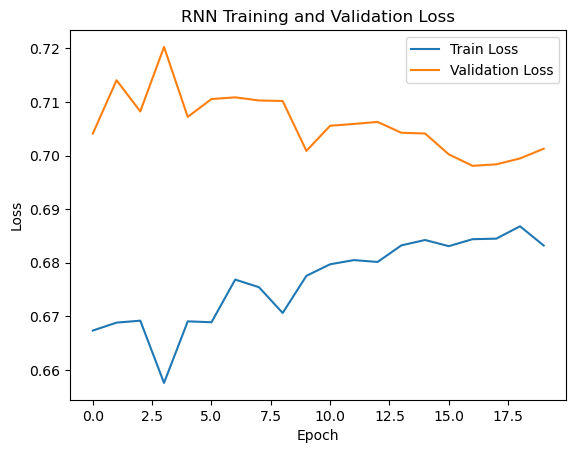

In [ ]:
plt.plot(losses_train_rnn, label='Train Loss')
plt.plot(losses_valid_rnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training and Validation Loss')
plt.legend()
plt.show()


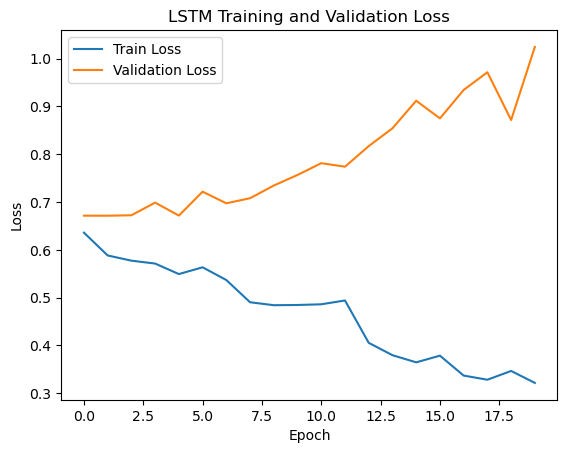

In [ ]:
plt.plot(losses_train_lstm, label='Train Loss')
plt.plot(losses_valid_lstm, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()

# Test

In [ ]:
X_test_cleaned = [lemma(text) for text in X_test]
test_max_length = max(len(sentence) for sentence in X_test_cleaned)
print(test_max_length)

31


In [ ]:
X_test_vector, y_test_vector = vectorize(X_test_cleaned, y_test)
print(X_test_vector.shape)
print(y_test_vector.shape)

(1104, 36, 100)
(1104,)


In [ ]:
def evaluate(model, X_test_vector, y_test_vector):
    outputs_test = model(torch.tensor(X_test_vector, dtype=torch.float32).to(device))

    predicted_label = torch.round(torch.sigmoid(outputs_test))
    predicted_labels = predicted_label.cpu().detach().numpy()
    true_labels = y_test_vector
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


In [ ]:
evaluate(rnn, X_test_vector, y_test_vector)

Accuracy: 0.5027173913043478
Precision: 0.28160919540229884
Recall: 0.45794392523364486
F1 Score: 0.3487544483985765


In [ ]:
evaluate(lstm, X_test_vector, y_test_vector)

Accuracy: 0.6376811594202898
Precision: 0.3713355048859935
Recall: 0.35514018691588783
F1 Score: 0.36305732484076436
